各種ライブラリのインポート

In [1]:
import numpy as np

In [2]:
print(np.__version__)

1.25.0


In [3]:
import lingam

In [4]:
print(lingam.__version__)

1.11.0


In [5]:
import pygam

In [6]:
print(pygam.__version__)

0.9.1


In [7]:
import sys

import numpy as np
import pandas as pd
import sklearn
import warnings
import os
import csv
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import graphviz
import lingam
from lingam.utils import print_causal_directions, print_dagc, make_dot
from lingam.utils import predict_adaptive_lasso
from lingam.bootstrap import BootstrapResult, BootstrapMixin

import numbers
from sklearn.utils import check_array, resample
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoLarsIC
from lingam.utils import print_causal_directions, print_dagc, make_dot, make_prior_knowledge

from pygam import LinearGAM, s

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

In [8]:
from pickle import FALSE
# numpyでの小数点以下桁数表示と指数表記の禁止を設定する
np.set_printoptions(precision=3, suppress=True)

# FutureWarning については非表示とする
warnings.simplefilter('ignore', FutureWarning)

# 積の構造的因果モデルのon/off
take_log = False
log_cutoff_for_zeros = -5

非線形因果探索に向けた基礎設定

In [9]:
np.random.seed(1)
tau_max = 1 # (number of lagged steps)-1
n_sampling = 1000 # bootstrap sampling number

In [10]:
#データセットを読み込む
X0 = pd.read_csv('241231_3type_lag1.csv', index_col=None)

#重点支援3類型でデータを分ける
X = [None for _ in range(3)]

X_array = [None for _ in range(3)]
for i_type in range(3):
    X[i_type] = X0[X0['support_type']==i_type+1]
    X[i_type] = X[i_type].drop(['FY', 'support_type'], axis=1)
    if take_log:
        X[i_type] = np.log10( np.maximum(X[i_type],10**log_cutoff_for_zeros) )
    X_array[i_type]= X[i_type].values

x_list = X[0].columns.tolist()
n_features = X[0].shape[1]//(tau_max+1)

In [11]:
x_list

['M_graduate',
 'D_entrance',
 'Ph.D_Graduate',
 'PosDoc',
 'AcaPos',
 'Basic_income',
 'Students_per_teacher',
 'DC1',
 'KAKEN',
 'Papers',
 'M_graduate_L1',
 'D_entrance_L1',
 'Ph.D_graduate_L1',
 'PosDoc_L1',
 'AcaPos_L1',
 'Basic_income_L1',
 'Students_per_teacher_L1',
 'DC1_L1',
 'KAKEN_L1',
 'Papers_L1']

事前知識の準備

In [18]:
def make_prior_knowledge_graph(prior_knowledge_matrix):
    d = graphviz.Digraph(engine='dot')

    labels = [f'x{i}' for i in range(prior_knowledge_matrix.shape[0])]
    for label in labels:
        d.node(label, label)

    dirs = np.where(prior_knowledge_matrix > 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        d.edge(labels[from_], labels[to])

    dirs = np.where(prior_knowledge_matrix < 0)
    for to, from_ in zip(dirs[0], dirs[1]):
        if to != from_:
            d.edge(labels[from_], labels[to], style='dashed')
    return d

In [19]:
prior_knowledge = np.loadtxt('250106_prior_knowledge_lag1.csv', delimiter=',',dtype ='int64')
prior_knowledge

array([[-1,  0, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [-1, -1, -1,  0,  0, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0],
       [-1, -1, -1, -1, -1, -1

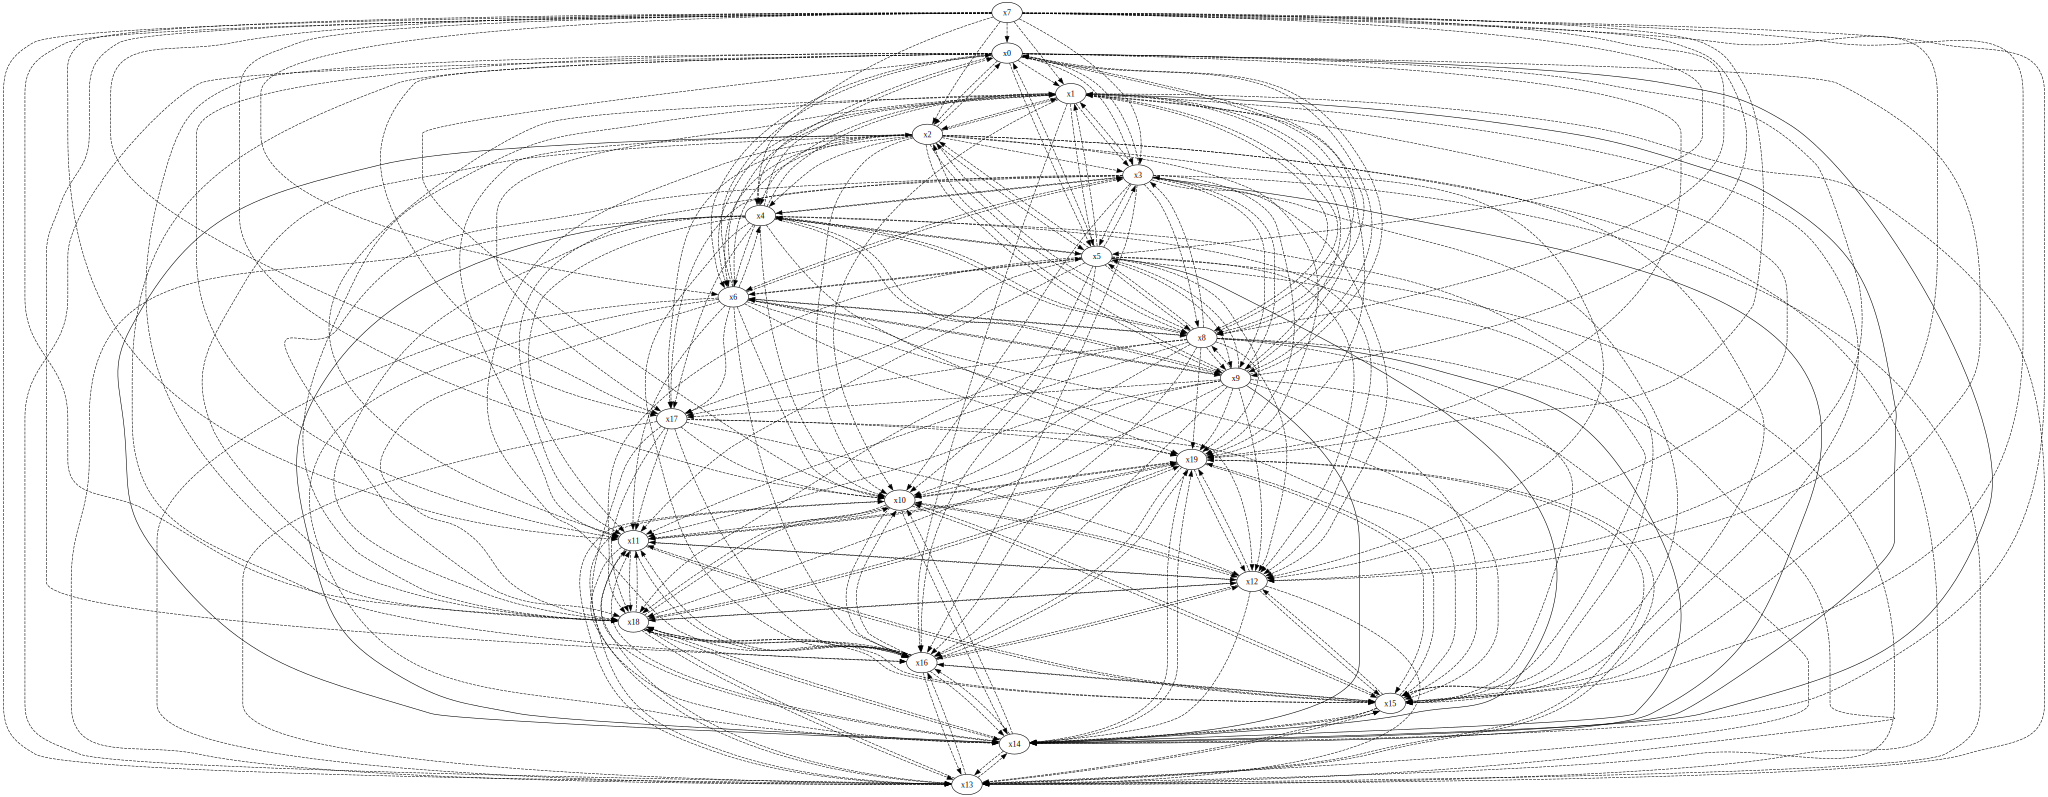

In [20]:
make_prior_knowledge_graph(prior_knowledge)

RESITの実行

In [21]:
class FreshGAM:
    def fit(self, X, y):
        self.model = LinearGAM().fit(X, y)  # ← 毎回新しい LinearGAM にリフレッシュ
        return self

    def predict(self, X):
        return self.model.predict(X)

In [20]:
#データセット全体の因果探索
for i_type in range(3):
        model = lingam.RESIT(regressor=FreshGAM(), prior_knowledge=prior_knowledge)
        result = model.fit(X[i_type])
        result_concatenated = model.adjacency_matrix_
        result_concatenated[0:n_features,:] = 0.0
        dot = make_dot(model.adjacency_matrix_, labels=x_list)
        dot.format = 'pdf'
        dot.render('./RESIT_GAM_support_group_' + str(i_type+1), view=False)
        np.savetxt('./RESIT_GAM_support_group_' + str(i_type+1)+'matrix.csv', result_concatenated, delimiter=',')
        print(result_concatenated)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0.

In [ ]:
bootstrapで因果効果の可視化

In [23]:
from lingam.utils import make_dot, visualize_nonlinear_causal_effect
import matplotlib.pyplot as plt
from lingam import RESIT

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

In [25]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.image as mpimg
import shutil

In [26]:
# bootstrapの並列化
import os, numbers, numpy as np, lingam
from joblib import Parallel, delayed
from sklearn.utils import check_array
from lingam.utils import calculate_total_effect

def _set_seed_everything(seed: int):
    np.random.seed(int(seed))
    # 必要なら他の乱数源もここで（例：random、torch など）
    # import random; random.seed(int(seed))

def _set_random_state_if_possible(model, seed: int):
    # estimatorや内包regressorにrandom_stateがあれば注入
    for attr in ["set_params", "get_params"]:
        if not hasattr(model, attr):
            break
    try:
        model.set_params(random_state=int(seed))
    except Exception:
        pass
    # よくあるパターン：model.regressor
    if hasattr(model, "regressor"):
        try:
            model.regressor.set_params(random_state=int(seed))
        except Exception:
            pass

def _worker(model, X, index, draw_idx, model_seed):
    # 乱数決定（モデルがglobal RNGを参照するケースも抑え込む）
    _set_seed_everything(model_seed)
    model = model(model_seed)  # できるならfactory内でもseedを使う

    # 逐次と同一の標本を使う
    resampled_X = X[draw_idx]
    resampled_index = index[draw_idx]

    # 万一のためにrandom_stateを注入（あれば）
    _set_random_state_if_possible(model, model_seed)

    model.fit(resampled_X)

    am = getattr(model, "adjacency_matrix_", getattr(model, "_adjacency_matrix"))
    co = getattr(model, "causal_order_", getattr(model, "_causal_order", np.arange(am.shape[0])))

    # RESITにおけるtotal_effectは慣例上0埋めでOK（線形前提の量）
    te = np.zeros_like(am, dtype=float)
    for c, frm in enumerate(co):
        for to in co[c+1:]:
            te[to, frm] = calculate_total_effect(am, frm, to)

    return am, te, resampled_index

def bootstrap_parallel(model, X, n_sampling, n_jobs=-1, base_seed=42):
    X = check_array(X)
    if not isinstance(n_sampling, (numbers.Integral, np.integer)) or n_sampling <= 0:
        raise ValueError("n_sampling must be an integer greater than 0.")

    n = X.shape[0]
    index = np.arange(n)

    # 親で全ての乱数を確定
    ss = np.random.SeedSequence(int(base_seed))
    child_ss = ss.spawn(int(n_sampling))
    draw_indices = []
    model_seeds = []
    for cs in child_ss:
        rng = np.random.default_rng(cs)
        draw_idx = rng.integers(0, n, size=n, endpoint=False)  # 復元抽出
        draw_indices.append(draw_idx)
        # モデル用seed（別系列）
        model_seeds.append(rng.integers(0, 2**31 - 1))

    results = Parallel(n_jobs=n_jobs, prefer="processes", batch_size=1)(
        delayed(_worker)(model, X, index, draw_indices[i], int(model_seeds[i]))
        for i in range(int(n_sampling))
    )

    adjacency_matrices = np.array([am for am, _, _ in results])
    total_effects = np.array([te for _, te, _ in results])
    resampled_indices = [idx for _, _, idx in results]

    return lingam.BootstrapResult(adjacency_matrices, total_effects, resampled_indices=resampled_indices)


In [27]:
# Parallel version of visualize_nonlinear_causal_effect (LiNGAM 1.10.0 based)
# Ref: lingam.utils._visualize_nonlinear_causal_effect (see docs)
# Parallelizes the bootstrap-loop part using joblib.Parallel.

import copy
import numpy as np
import pandas as pd
from joblib import Parallel, delayed

from sklearn.utils import check_array
from sklearn.base import is_regressor, is_classifier
try:
    from sklearn.base import clone
except Exception:
    clone = None

import matplotlib.pyplot as plt
from matplotlib.figure import Figure


def visualize_nonlinear_causal_effect_parallel(
    X,
    cd_result,
    estimator,
    cause_name,
    effect_name,
    cause_positions=None,
    percentile=None,
    fig=None,
    boxplot=False,
    *,
    n_jobs=-1,
    prefer="processes",      # "threads" も指定可
    base_seed=None,          # 再現性を確保したい場合に設定
    estimator_factory=None,  
):

    # -------- argument checks (same as upstream) --------
    if not isinstance(X, pd.DataFrame):
        raise TypeError("X must be pandas.DataFrame.")

    if not _is_bootstrap_result(cd_result) and not _is_adjacency_matrix(cd_result, X.shape[1]):
        raise TypeError("cd_result must be lingam.bootstrap.BootstrapResult or array-like.")

    if cause_name not in X.columns:
        raise ValueError("cause_name is not exsit in X.columns.")
    if X[cause_name].dtype == "category":
        raise ValueError("cause_name must not be categorical.")

    if effect_name not in X.columns:
        raise ValueError("effect_name is not exsit in X.columns.")

    is_discrete = X[effect_name].dtype == "category"
    _check_estimator(estimator, is_discrete)

    if cause_positions is not None:
        cause_positions = check_array(cause_positions, dtype=None, ensure_2d=False).flatten()
        if None in cause_positions:
            raise TypeError("cause_positions must not include None.")

    if percentile is not None:
        if not isinstance(percentile, list) or len(percentile) != 3:
            raise TypeError("percentile must be a list of 3 floats.")
        if not all(map(lambda x: 0 <= x <= 100, percentile)):
            raise TypeError("Elements of percentile must be between 0 and 100 inclusive.")

    if fig is not None and not isinstance(fig, Figure):
        raise TypeError("fig must be matplotlib.figure.Figure.")

    # -------- defaults / initial values (same as upstream) --------
    if cause_positions is None:
        cause_positions = np.linspace(X[cause_name].min(), X[cause_name].max(), 10)

    if fig is None:
        fig = plt.figure()

    cause_index = list(X.columns).index(cause_name)
    effect_index = list(X.columns).index(effect_name)
    effect_classes = [None] if not is_discrete else np.unique(X[effect_name])

    if percentile is None:
        percentile = (95, 50, 5)

    # -------- prepare matrices & indices (same as upstream) --------
    if _is_bootstrap_result(cd_result):
        adj_matrices = cd_result.adjacency_matrices_
        index_list = cd_result.resampled_indices_
        if index_list is None:
            index_list = [X.index] * len(adj_matrices)
        disable_percentile = False
    else:
        adj_matrices = [cd_result]
        index_list = [X.index]
        disable_percentile = True

    # -------- deterministic seeds for parallel (optional) --------
    if base_seed is None:
        # OS 乱数に任せる
        seeds = [None] * len(adj_matrices)
    else:
        ss = np.random.SeedSequence(int(base_seed))
        seeds = [np.random.default_rng(s).integers(0, 2**31 - 1) for s in ss.spawn(len(adj_matrices))]

    # -------- worker: do one bootstrap iteration --------
    def _make_estimator(seed):
        if estimator_factory is not None:
            return estimator_factory(seed)
        # try sklearn.clone first (より軽量・確実)
        if clone is not None:
            try:
                return clone(estimator)
            except Exception:
                pass
        # fallback: deepcopy
        return copy.deepcopy(estimator)

    def _one_iter(m, sub_index, seed):
        # parents of cause except effect
        covariate = np.where(m[cause_index, :] == 1)[0].tolist()
        # remove effect_index if present
        covariate = np.delete(covariate, np.argwhere(np.asarray(covariate) == effect_index))

        # explanatory indices (cause + covariates) excluding effect
        exp = np.sort([cause_index] + np.asarray(covariate).tolist())
        exp = np.delete(exp, np.argwhere(exp == effect_index))

        X_exp = pd.get_dummies(X.iloc[sub_index, exp])
        X_obj = X.iloc[sub_index, effect_index]

        est = _make_estimator(seed)
        # ベストエフォートで random_state を注入
        try:
            est.set_params(random_state=None if seed is None else int(seed))
        except Exception:
            pass

        est.fit(X_exp, X_obj)

        # return per-class-per-position values for this iteration
        out = {}

        if not is_discrete:
            # continuous effect
            key = None
            out[key] = {}
            for interv_val in cause_positions:
                X_ = X.iloc[sub_index, :].copy()
                X_.iloc[:, cause_index] = interv_val
                X_exp2 = pd.get_dummies(X_.iloc[:, exp])

                # 元実装と同様：特に列アラインは行わない（忠実性重視）
                vals = est.predict(X_exp2)
                out[key][interv_val] = float(np.mean(vals))
        else:
            # classification: use predict_proba
            for interv_val in cause_positions:
                X_ = X.iloc[sub_index, :].copy()
                X_.iloc[:, cause_index] = interv_val
                X_exp2 = pd.get_dummies(X_.iloc[:, exp])

                probs = est.predict_proba(X_exp2)
                # estimator.classes_ に存在するクラスのみ返す（元実装の挙動）
                for i, c in enumerate(est.classes_):
                    out.setdefault(c, {})
                    out[c][interv_val] = float(np.mean(probs[:, i]))
        return out

    # -------- run in parallel over bootstrap iterations --------
    per_iter = Parallel(n_jobs=n_jobs, prefer=prefer, batch_size=1)(
        delayed(_one_iter)(m, sub_idx, seeds[i])
        for i, (m, sub_idx) in enumerate(zip(adj_matrices, index_list))
    )

    # -------- aggregate like upstream (_calculate) --------
    effect_info = {c: {p: [] for p in cause_positions} for c in effect_classes}
    for it_out in per_iter:
        for c in effect_info.keys():
            pos2val = it_out.get(c, {})
            for p in cause_positions:
                if p in pos2val:
                    effect_info[c][p].append(pos2val[p])
                # else: クラス欠落時はスキップ（元実装と同様の「短いリスト」）

    # -------- draw (same as upstream) --------
    fig = _draw(effect_info, cause_positions, percentile, fig,
                cause_name, effect_name, boxplot, disable_percentile)
    return fig


# ===== helpers copied / adapted from upstream =====

def _is_bootstrap_result(cd_result):
    name = type(cd_result).__module__ + "." + type(cd_result).__name__
    return name == "lingam.bootstrap.BootstrapResult"

def _is_adjacency_matrix(cd_result, col_num):
    check_array(cd_result)
    return cd_result.shape[0] == col_num and cd_result.shape[1] == col_num

def _check_estimator(estimator, is_discrete):
    if is_discrete and is_regressor(estimator):
        raise TypeError("X[effect_name] is discrete but the estimator is a regressor.")
    elif (not is_discrete) and is_classifier(estimator):
        raise TypeError("X[effect_name] is not discrete but the estimator is a classifier.")
    if is_classifier(estimator):
        func = getattr(estimator, "predict_proba", None)
        if not callable(func):
            raise RuntimeError("Classification models must have predict_proba().")

def _draw(effect_info, cause_positions, percentile, fig,
          cause_name, effect_name, is_box, disable_percentile):
    # same plotting logic as upstream
    if disable_percentile is False:
        alpha = 0.5
        colors = ["red", "green", "blue"]
    else:
        percentile = [50]
        alpha = 1.0
        colors = ["green"]

    for i in range(len(effect_info)):
        fig.add_subplot(1, len(effect_info), i + 1)
    axes = np.array(fig.get_axes()).flatten()

    for ax, (class_name, effects) in zip(axes, effect_info.items()):
        per_plot = {per: [] for per in percentile}
        for interv_val, values in effects.items():
            if not is_box:
                ax.scatter(
                    interv_val * np.ones(len(values)),
                    values,
                    color="black",
                    alpha=alpha,
                    facecolor="none",
                )
            else:
                ax.boxplot(values, positions=[interv_val], manage_ticks=False)

            per_points = np.percentile(values, percentile)
            for per_point, percentile_ in zip(per_points, percentile):
                per_plot[percentile_].append(per_point)

        ax.set_xlabel(cause_name)
        if class_name is None:
            ax.set_ylabel(f"causal effect {effect_name}")
        else:
            ax.set_ylim(-0.05, 1.05)
            ax.set_title(f"class {class_name}")
            ax.set_ylabel("probability")

        for (per, values), color in zip(per_plot.items(), colors):
            label = f"{per}%" if disable_percentile is False else None
            ax.plot(cause_positions, values, color=color, label=label)

    return fig


In [28]:
import time

In [29]:
def make_resit_model(seed):
    reg = FreshGAM()
    return lingam.RESIT(regressor=reg, prior_knowledge=prior_knowledge)

In [ ]:
#第Ⅰ類型

In [36]:
start_time = time.time()

bs_result1 = bootstrap_parallel(make_resit_model, X[0], n_sampling=1000, n_jobs=-1, base_seed = 123)

end_time = time.time()
duration = end_time - start_time
print(f"{duration:.2f} seconds")

prob1 = bs_result1.get_probabilities(min_causal_effect=0.01)
np.savetxt('./RESIT_GAM_bootprob_support_group_1matrix.csv', prob1, delimiter=',')
print(prob1)

9284.15 seconds
[[0.    0.    0.754 0.605 0.27  0.01  0.479 0.875 0.162 0.01  0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [1.    0.    0.821 0.72  0.328 0.01  0.484 0.999 0.163 0.015 0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.178 0.178 0.    0.    0.    0.    0.199 1.    0.134 0.001 0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.275 0.276 0.997 0.    0.329 0.03  0.451 0.998 0.29  0.031 0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.672 0.672 1.    0.671 0.    0.    0.605 1.    0.313 0.016 0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.823 0.745 0.768 0.711 0.788 0.    0.999 0.808 0.974 0.693 0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.516 0.516 0.801 0.549 0.395 0.    0.    1.    0.099 0.008 0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.837 

In [ ]:
#第Ⅱ類型

In [28]:
start_time = time.time()

bs_result2 = bootstrap_parallel(make_resit_model, X[1], n_sampling=1000, n_jobs=-1, base_seed = 123)

end_time = time.time()
duration = end_time - start_time
print(f"{duration:.2f} seconds")

prob2 = bs_result2.get_probabilities(min_causal_effect=0.01)
np.savetxt('./RESIT_GAM_bootprob_support_group_2matrix.csv', prob2, delimiter=',')
print(prob2)

2707.43 seconds
[[0.    0.    0.44  0.292 0.152 0.332 0.239 0.838 0.105 0.145 0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.567 0.    0.37  0.451 0.252 0.418 0.276 0.522 0.206 0.207 0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.221 0.084 0.    0.    0.    0.331 0.128 0.894 0.093 0.14  0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.412 0.225 0.601 0.    0.148 0.314 0.237 0.745 0.122 0.181 0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.422 0.302 0.438 0.247 0.    0.345 0.192 0.501 0.134 0.244 0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.428 0.226 0.369 0.326 0.188 0.    0.338 0.772 0.242 0.296 0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.277 0.207 0.463 0.291 0.249 0.631 0.    0.702 0.195 0.241 0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.295 

In [ ]:
#第Ⅲ類型

In [30]:
start_time = time.time()

bs_result3 = bootstrap_parallel(make_resit_model, X[2], n_sampling=1000, n_jobs=-1, base_seed = 123)

end_time = time.time()
duration = end_time - start_time
print(f"{duration:.2f} seconds")

prob3= bs_result3.get_probabilities(min_causal_effect=0.01)
np.savetxt('./RESIT_GAM_bootprob_support_group_3matrix.csv', prob3, delimiter=',')
print(prob3)

4566.29 seconds
[[0.    0.    0.463 0.349 0.066 0.678 0.416 0.466 0.536 0.182 0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.415 0.    0.33  0.27  0.096 0.312 0.285 0.395 0.712 0.289 0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.083 0.043 0.    0.    0.    0.278 0.479 0.712 0.446 0.187 0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.28  0.184 0.908 0.    0.163 0.528 0.443 0.806 0.429 0.345 0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.421 0.362 0.228 0.151 0.    0.204 0.748 0.18  0.319 0.264 0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.235 0.142 0.402 0.348 0.115 0.    0.432 0.864 0.464 0.157 0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.098 0.049 0.297 0.278 0.021 0.516 0.    0.951 0.284 0.12  0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.114 

In [31]:
from_index = 7 # index of x7
to_index = 1 # index of x1

pd.DataFrame(bs_result3.get_paths(from_index, to_index))

,path,effect,probability
0,"[7, 8, 1]",1.0,0.693
1,"[7, 6, 8, 1]",1.0,0.437
2,"[7, 1]",1.0,0.395
3,"[7, 5, 1]",1.0,0.280
4,"[7, 5, 0, 1]",1.0,0.274
...,...,...,...
2852,"[7, 5, 6, 8, 2, 4, 0, 1]",1.0,0.001
2853,"[7, 5, 6, 8, 2, 3, 4, 1]",1.0,0.001
2854,"[7, 5, 6, 8, 2, 0, 9, 1]",1.0,0.001
2855,"[7, 5, 6, 9, 0, 4, 1]",1.0,0.001


In [33]:
from_index = 0 # index of x0
to_index = 19 # index of x19

pd.DataFrame(bs_result3.get_paths(from_index, to_index))

,path,effect,probability
0,"[0, 19]",1.0,0.587
1,"[0, 17, 19]",1.0,0.552
2,"[0, 13, 19]",1.0,0.498
3,"[0, 9, 19]",1.0,0.448
4,"[0, 9, 17, 19]",1.0,0.404
...,...,...,...
75719,"[0, 4, 12, 13, 16, 11, 18, 15, 19]",1.0,0.001
75720,"[0, 1, 4, 17, 16, 18, 11, 15, 19]",1.0,0.001
75721,"[0, 1, 4, 17, 16, 18, 10, 15, 19]",1.0,0.001
75722,"[0, 1, 4, 17, 16, 14, 11, 19]",1.0,0.001


In [34]:
from_index = 8 # index of x8
to_index = 12 # index of x12

pd.DataFrame(bs_result3.get_paths(from_index, to_index))

,path,effect,probability
0,"[8, 12]",1.0,0.565
1,"[8, 17, 12]",1.0,0.472
2,"[8, 9, 12]",1.0,0.340
3,"[8, 9, 17, 12]",1.0,0.296
4,"[8, 1, 17, 12]",1.0,0.295
...,...,...,...
54515,"[8, 5, 0, 9, 1, 3, 10, 11, 18, 12]",1.0,0.001
54516,"[8, 5, 0, 9, 1, 3, 10, 11, 19, 12]",1.0,0.001
54517,"[8, 5, 0, 9, 1, 3, 10, 11, 19, 18, 12]",1.0,0.001
54518,"[8, 5, 0, 9, 1, 3, 17, 10, 11, 19, 12]",1.0,0.001


In [35]:
from_index = 1 # index of x1
to_index = 17 # index of x17

pd.DataFrame(bs_result3.get_paths(from_index, to_index))

,path,effect,probability
0,"[1, 17]",1.0,0.794
1,"[1, 4, 17]",1.0,0.285
2,"[1, 9, 17]",1.0,0.220
3,"[1, 3, 17]",1.0,0.149
4,"[1, 5, 17]",1.0,0.110
...,...,...,...
366,"[1, 2, 9, 8, 17]",1.0,0.001
367,"[1, 2, 9, 5, 8, 3, 17]",1.0,0.001
368,"[1, 6, 2, 3, 4, 17]",1.0,0.001
369,"[1, 5, 9, 3, 4, 17]",1.0,0.001


In [ ]:
bootstrapの結果を使って、ここから可視化

In [44]:
# 第一類型
os.makedirs("temp_figs", exist_ok=True)
counter = 0
for f1 in range(20):
    for i in range(20):
        to_index = i
        from_index = f1

        if from_index >9 and to_index <10:
            continue

        if from_index == to_index:
            blank = np.ones((600, 900, 3), dtype=np.float32)  # HxW（任意サイズ）
            plt.imsave(f"temp_figs/fig_GAM_1_{counter}.png", blank)  # 真っ白PNGを保存
            counter += 1
            continue

        # 呼び出しと保存
        fig = visualize_nonlinear_causal_effect_parallel(
            X=X[0], 
            cd_result=bs_result1, 
            estimator=FreshGAM(),
            cause_name=x_list[from_index], 
            effect_name=x_list[to_index],
            estimator_factory=lambda seed: FreshGAM(),  # 必要なら random_state=seed を渡す
            n_jobs=-1, 
            base_seed=123
        )
        #fig = visualize_nonlinear_causal_effect(
        #    X[0],
        #    bs_result1,
        #    FreshGAM(),
        #    x_list[from_index],
        #    x_list[to_index]
        #)

        fig.tight_layout()
        fig_path = f"temp_figs/fig_GAM_1_{counter}.png"
        fig.savefig(fig_path)
        counter += 1
        plt.close(fig)

# ここから1ページ目に敷き詰める
figure_title = 'RESIT_GAM_visual_support_group_1.pdf'
pdf = PdfPages(figure_title)

total_figs = 300
figs_per_page = 10
rows, cols = 2, 5

for page_start in range(0, total_figs, figs_per_page):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(figs_per_page):
        fig_index = page_start + i
        if fig_index >= total_figs:
            axes[i].axis('off')  # 空白スロットは非表示
        else:
            img = mpimg.imread(f"temp_figs/fig_GAM_1_{fig_index}.png")
            axes[i].imshow(img)
            axes[i].axis('off')

    fig.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)

pdf.close()

In [42]:
# 第二類型
os.makedirs("temp_figs", exist_ok=True)
counter = 0
for f2 in range(20):
    for i in range(20):
        to_index = i
        from_index = f2

        if from_index >9 and to_index <10:
            continue

        if from_index == to_index:
            blank = np.ones((600, 900, 3), dtype=np.float32)  # HxW（任意サイズ）
            plt.imsave(f"temp_figs/fig_GAM_2_{counter}.png", blank)  # 真っ白PNGを保存
            counter += 1
            continue

        # 呼び出しと保存
        fig = visualize_nonlinear_causal_effect_parallel(
            X=X[1], 
            cd_result=bs_result2, 
            estimator=FreshGAM(),
            cause_name=x_list[from_index], 
            effect_name=x_list[to_index],
            estimator_factory=lambda seed: FreshGAM(),  # 必要なら random_state=seed を渡す
            n_jobs=-1, 
            base_seed=123
        )
        #fig = visualize_nonlinear_causal_effect(
        #    X[0],
        #    bs_result1,
        #    FreshGAM(),
        #    x_list[from_index],
        #    x_list[to_index]
        #)

        fig.tight_layout()
        fig_path = f"temp_figs/fig_GAM_2_{counter}.png"
        fig.savefig(fig_path)
        counter += 1
        plt.close(fig)

# ここから1ページ目に敷き詰める
figure_title = 'RESIT_GAM_visual_support_group_2.pdf'
pdf = PdfPages(figure_title)

total_figs = 300
figs_per_page = 10
rows, cols = 2, 5

for page_start in range(0, total_figs, figs_per_page):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(figs_per_page):
        fig_index = page_start + i
        if fig_index >= total_figs:
            axes[i].axis('off')  # 空白スロットは非表示
        else:
            img = mpimg.imread(f"temp_figs/fig_GAM_2_{fig_index}.png")
            axes[i].imshow(img)
            axes[i].axis('off')

    fig.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)

pdf.close()

In [43]:
# 第三類型
os.makedirs("temp_figs", exist_ok=True)
counter = 0
for f3 in range(20):
    for i in range(20):
        to_index = i
        from_index = f3

        if from_index >9 and to_index <10:
            continue

        if from_index == to_index:
            blank = np.ones((600, 900, 3), dtype=np.float32)  # HxW（任意サイズ）
            plt.imsave(f"temp_figs/fig_GAM_3_{counter}.png", blank)  # 真っ白PNGを保存
            counter += 1
            continue

        # 呼び出しと保存
        fig = visualize_nonlinear_causal_effect_parallel(
            X=X[2], 
            cd_result=bs_result3, 
            estimator=FreshGAM(),
            cause_name=x_list[from_index], 
            effect_name=x_list[to_index],
            estimator_factory=lambda seed: FreshGAM(),  # 必要なら random_state=seed を渡す
            n_jobs=-1, 
            base_seed=123
        )
        #fig = visualize_nonlinear_causal_effect(
        #    X[0],
        #    bs_result1,
        #    FreshGAM(),
        #    x_list[from_index],
        #    x_list[to_index]
        #)

        fig.tight_layout()
        fig_path = f"temp_figs/fig_GAM_3_{counter}.png"
        fig.savefig(fig_path)
        counter += 1
        plt.close(fig)

# ここから1ページ目に敷き詰める
figure_title = 'RESIT_GAM_visual_support_group_3.pdf'
pdf = PdfPages(figure_title)

total_figs = 300
figs_per_page = 10
rows, cols = 2, 5

for page_start in range(0, total_figs, figs_per_page):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(figs_per_page):
        fig_index = page_start + i
        if fig_index >= total_figs:
            axes[i].axis('off')  # 空白スロットは非表示
        else:
            img = mpimg.imread(f"temp_figs/fig_GAM_3_{fig_index}.png")
            axes[i].imshow(img)
            axes[i].axis('off')

    fig.tight_layout()
    pdf.savefig(fig)
    plt.close(fig)

pdf.close()